#**LAB-03 REDES CONVOLUCIONALES TRANSFER LEARNING**

##Dirección de GitHub: https://github.com/Gonzales-Franz-Reinaldo/SIS421-IA2/tree/main/Laboratorios/LAB-03_CNN

##CONTEXTO DEL LABORATORIO

Elaborar:

2. Realizar lo solicitado en el punto 1, pero utilizando un modelo preentrenado y aplicando tecnicas de transfer learning y fine tunning.

Se debe elaborar un informe en relacion a los resultados que se obtengan en cada parte del trabajo.

El cuadernillo a presentar solo debe tener informacion que el estudiante considere necesaria.

Se debe subir el cuadernillo a ecampus y a su repositorio, para lo cual se debe incluir la dirección del mismo.

Se recomienda realizar un trabajo responsable y detallado, por cuanto este trabajo tiene una calificación especial y es parte del examen del primer parcial, por lo cual codigos que se identifiquen copia o no sean adecuadamente defendidos seran considerados como copia o no validos.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Comprobar si hay GPU disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


#1. Preparación del Dataset

In [ ]:
# Definir las transformaciones para las imágenes
transformaciones = transforms.Compose([
    transforms.Resize((50, 50)),  # Redimensionar las imágenes a 50x50 píxeles
    transforms.ToTensor(),  # Convertir las imágenes a tensores
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalizar usando los valores de los modelos preentrenados
])


In [ ]:
# CARGAR LOS DATASET

# CARGAMOS LOS DATASET DE ENTRENAMIENTO Y PRUEBA

import torch
from torch.utils.data import Dataset, DataLoader

class PlantasDataset(Dataset):
    def __init__(self, archivo_dataset, transform=None):
        self.imagenes, self.etiquetas = torch.load(archivo_dataset)
        self.transform = transform

    def __len__(self):
        return len(self.etiquetas)

    def __getitem__(self, idx):
        imagen = self.imagenes[idx]
        etiqueta = self.etiquetas[idx]

        if self.transform:
            imagen = self.transform(imagen)

        return imagen, etiqueta


# Cargar datasets
trainset = PlantasDataset('/content/drive/MyDrive/SIS420-IA2/Dataset/plants_train.pt')
testset = PlantasDataset('/content/drive/MyDrive/SIS420-IA2/Dataset/plants_test.pt')


print("Número de ejemplos en el conjunto de entrenamiento:", len(trainset))
print("Número de ejemplos en el conjunto de prueba:", len(testset))


<ipython-input-5-a82c6116c0bb>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.imagenes, self.etiquetas = torch.load(archivo_dataset)


Número de ejemplos en el conjunto de entrenamiento: 60000
Número de ejemplos en el conjunto de prueba: 15000


In [ ]:
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=4)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
class ModelCustom(torch.nn.Module):
  def __init__(self, n_outputs=5, pretrained=False, freeze=False):
    super().__init__()
    # descargamos resnet
    resnet = torchvision.models.resnet18(pretrained=pretrained)
    # nos quedamos con todas las capas menos la última
    self.resnet = torch.nn.Sequential(*list(resnet.children())[:-1])
    if freeze:
      for param in self.resnet.parameters():
        param.requires_grad=False
    # añadimos una nueva capa lineal para llevar a cabo la clasificación
    self.fc = torch.nn.Linear(512, 5)

  def forward(self, x):
    x = self.resnet(x)
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

  def unfreeze(self):
    for param in self.resnet.parameters():
        param.requires_grad=True

## Cargar el modelo ResNet preentrenado

Aquí cargamos el modelo ResNet preentrenado y lo adaptamos para la clasificación de nuestras 5 clases de plantas.

In [ ]:
import torchvision

resnet = torchvision.models.resnet18()
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Cargar el modelo preentrenado ResNet

In [ ]:
# Cargar el modelo preentrenado ResNet
modelo = models.resnet18(pretrained=True)

# Congelar las capas del modelo para evitar su entrenamiento inicial (Transfer Learning)
for param in modelo.parameters():
    param.requires_grad = False

# Reemplazar la última capa completamente conectada para que coincida con nuestro número de clases
num_ftrs = modelo.fc.in_features
modelo.fc = nn.Linear(num_ftrs, 5)  # 5 clases de plantas

modelo = modelo.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 136MB/s]


##Definir la función de pérdida y el optimizador

Aplicaremos la técnica de Fine Tuning, por lo que seleccionamos un optimizador que ajustará solo los parámetros de la última capa.

In [ ]:
# Definir la función de pérdida y el optimizador
criterio = nn.CrossEntropyLoss()
optimizador = optim.SGD(modelo.fc.parameters(), lr=0.001, momentum=0.9)


##Entrenamiento del modelo

El proceso de entrenamiento incluye la fase de Transfer Learning seguida de Fine Tuning. Primero, entrenaremos solo la última capa y luego desbloquearemos algunas capas adicionales para ajustar todo el modelo.

In [ ]:
from tqdm import tqdm
import torch.optim as optim

# Función de entrenamiento
def entrenar_modelo(modelo, criterion, optimizer, epochs=10, num_checkpoint=5):
    for epoch in range(epochs):
        modelo.train()
        running_loss = 0.0

        for inputs, labels in tqdm(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = modelo(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(trainloader.dataset)
        print(f"Epoch {epoch+1}/{epochs}, Pérdida: {epoch_loss:.4f}")

        # Guardar el checkpoint cada num_checkpoint epochs
        if (epoch + 1) % num_checkpoint == 0:
            checkpoint_path = f'/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/checkpoint2_{epoch+1}.pth'
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': modelo.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': epoch_loss,
            }, checkpoint_path)
            print(f'Checkpoint saved to {checkpoint_path}')

In [ ]:
# Transfer Learning: Entrenar solo la última capa
entrenar_modelo(modelo, criterio, optimizador, epochs=5, num_checkpoint=2)

# Guardar el modelo completo después del entrenamiento de Transfer Learning
modelo_completo_path = '/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/plants_resnet_transfer_learning.pth'
torch.save(modelo.state_dict(), modelo_completo_path)
print(f'Modelo entrenado guardado en {modelo_completo_path}')


100%|██████████| 938/938 [08:09<00:00,  1.92it/s]


Epoch 1/5, Pérdida: 0.7172


100%|██████████| 938/938 [08:13<00:00,  1.90it/s]


Epoch 2/5, Pérdida: 0.5552
Checkpoint saved to /content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/checkpoint2_2.pth


100%|██████████| 938/938 [08:15<00:00,  1.89it/s]


Epoch 3/5, Pérdida: 0.5334


100%|██████████| 938/938 [08:13<00:00,  1.90it/s]


Epoch 4/5, Pérdida: 0.5196
Checkpoint saved to /content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/checkpoint2_4.pth


100%|██████████| 938/938 [08:08<00:00,  1.92it/s]


Epoch 5/5, Pérdida: 0.5155
Modelo entrenado guardado en /content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/plants_resnet_transfer_learning.pth


##**FINE TUNING**

El fine tinig es para

In [ ]:
# Desbloquear algunas capas adicionales para Fine Tuning
for param in modelo.parameters():
    param.requires_grad = True


# Reentrenar con Fine Tuning
optimizador = optim.SGD(modelo.parameters(), lr=0.0001, momentum=0.9)
entrenar_modelo(modelo, criterio, optimizador, epochs=10, num_checkpoint=5)

100%|██████████| 938/938 [23:52<00:00,  1.53s/it]


Epoch 1/10, Pérdida: 0.1941


100%|██████████| 938/938 [23:57<00:00,  1.53s/it]


Epoch 2/10, Pérdida: 0.0471


100%|██████████| 938/938 [24:02<00:00,  1.54s/it]


Epoch 3/10, Pérdida: 0.0244


100%|██████████| 938/938 [23:58<00:00,  1.53s/it]


Epoch 4/10, Pérdida: 0.0157


100%|██████████| 938/938 [23:53<00:00,  1.53s/it]


Epoch 5/10, Pérdida: 0.0119
Checkpoint saved to /content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/checkpoint2_5.pth


100%|██████████| 938/938 [24:01<00:00,  1.54s/it]


Epoch 6/10, Pérdida: 0.0084


100%|██████████| 938/938 [24:17<00:00,  1.55s/it]


Epoch 7/10, Pérdida: 0.0074


100%|██████████| 938/938 [23:57<00:00,  1.53s/it]


Epoch 8/10, Pérdida: 0.0064


100%|██████████| 938/938 [24:08<00:00,  1.54s/it]


Epoch 9/10, Pérdida: 0.0052


100%|██████████| 938/938 [24:06<00:00,  1.54s/it]


Epoch 10/10, Pérdida: 0.0043
Checkpoint saved to /content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/checkpoint2_10.pth


##CARGAMOS LOS MODELOS ENTRENADOS.

In [ ]:
import torch
import torch.nn as nn
import copy

# Assuming 'modelo' is the original ResNet model architecture
modelo_transf_lear = copy.deepcopy(modelo)  # Create a new instance of the model
modelo_transf_lear.load_state_dict(torch.load('/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/plants_resnet_transfer_learning.pth'))
modelo_transf_lear.eval()  # Now you can call eval() on the new model instance

# Use modelo_transf_lear for further operations

<ipython-input-13-e3a14d09b838>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  modelo_transf_lear.load_state_dict(torch.load('/content/drive/MyDrive/SIS420-IA2/Laboratorio

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

##Evaluar el modelo

In [ ]:
def evaluar_modelo(modelo):
    modelo.eval()
    correctos = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = modelo(inputs)
            _, predicciones = torch.max(outputs, 1)
            total += labels.size(0)
            correctos += (predicciones == labels).sum().item()

    precision = 100 * correctos / total
    print(f"Precisión en el conjunto de prueba: {precision:.2f}%")

evaluar_modelo(modelo_transf_lear)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Precisión en el conjunto de prueba: 82.68%


##PRUEBAS CON UNA IMAGEN FOTOGRÁFICA

In [38]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Definir las transformaciones para las imágenes (debe coincidir con las del entrenamiento)
transform = transforms.Compose([
    transforms.Resize((50, 50)),  # Reducir el tamaño de la imagen a 50x50 píxeles
    transforms.ToTensor(),  # Convertir las imágenes a tensores
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalizar los tensores
])


In [ ]:
# Función para hacer predicciones
def predict_image(image_path):
    # Cargar la imagen
    image = Image.open(image_path)

    # Aplicar las transformaciones
    image_tensor = transform(image).unsqueeze(0)  # Añadir una dimensión para el batch

    # Realizar la predicción
    with torch.no_grad():
        outputs = modelo_transf_lear(image_tensor)
        _, predicted = torch.max(outputs, 1)

    return predicted.item()



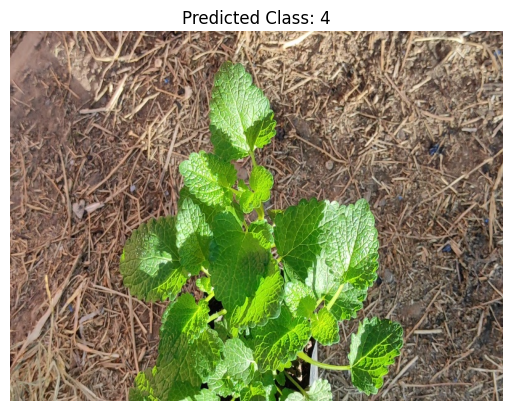

In [ ]:
# Ruta de la imagen a probar
# image_path = '/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/Images_prueba/acelga_08989.jpg'  # Cambia esto a la ruta de tu imagen
# image_path = '/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/Images_prueba/cebolla_00386.jpg'
# image_path = '/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/Images_prueba/espinaca_00408.jpg'
# image_path = '/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/Images_prueba/lechuga_00066.jpg'
image_path = '/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/Images_prueba/toronjil_00022.jpg'

# Obtener la clase predicha
predicted_class = predict_image(image_path)

# Mostrar la imagen y el resultado
image = Image.open(image_path)
plt.imshow(image)
plt.title(f'Predicted Class: {predicted_class}')
plt.axis('off')
plt.show()

In [ ]:
# OTRAS MANERA DE PREDECIR EL MODELO

# Cargar la imagen para prueba
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Añadir una dimensión para el batch
    return image

# Realizar una prueba con una imagen cargada
def predict(image_path):
    image = load_image(image_path)
    with torch.no_grad():
        outputs = modelo_transf_lear(image)
        _, predicted = torch.max(outputs.data, 1)
        return predicted.item()

# Ejemplo de uso
image_path = '/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/Images_prueba/acelga_08989.jpg'  # Reemplaza con la ruta a tu imagen
predicted_class = predict(image_path)
print(f'Predicted class: {predicted_class}')


Predicted class: 4


##PROBANDO OTRAS MANERA DE ENTRENAMIENTO DEL MODELO CON TRANSFER LEARNING

##Transfer Learning

In [ ]:
from tqdm import tqdm
import numpy as np
import torch.optim as optim
import torch.nn as nn

def fit(model, dataloader_train, dataloader_test, epochs=5, lr=1e-2):
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader_train)
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader_test)
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

    # Guardar el modelo completo al final del entrenamiento
    checkpoint_path = '/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/modelo_RC_Transfer_Learning.pth'
    torch.save({
        'epoch': epochs,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': np.mean(val_loss),
    }, checkpoint_path)
    print(f'Modelo completo guardado en {checkpoint_path}')


In [32]:
model_c = ModelCustom(pretrained=True, freeze=True)
fit(model_c, trainloader, testloader)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader ru

Epoch 1/5 loss 0.71245 val_loss 0.55499 acc 0.74590 val_acc 0.80578


val_loss 0.51568 val_acc 0.81500: 100%|██████████| 235/235 [02:02<00:00,  1.92it/s]


Epoch 2/5 loss 0.55994 val_loss 0.51568 acc 0.79947 val_acc 0.81500


val_loss 0.50457 val_acc 0.81948: 100%|██████████| 235/235 [02:01<00:00,  1.93it/s]


Epoch 3/5 loss 0.53262 val_loss 0.50457 acc 0.80837 val_acc 0.81948


val_loss 0.49972 val_acc 0.82172: 100%|██████████| 235/235 [02:01<00:00,  1.93it/s]


Epoch 4/5 loss 0.52337 val_loss 0.49972 acc 0.81367 val_acc 0.82172


val_loss 0.49453 val_acc 0.82108: 100%|██████████| 235/235 [02:01<00:00,  1.93it/s]


Epoch 5/5 loss 0.51046 val_loss 0.49453 acc 0.81540 val_acc 0.82108
Modelo completo guardado en /content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/modelo_RC_Transfer_Learning.pth


##Fine Runing

Todavía podemos mejorar un poco más si, además de utilizar los pesos descargados de Imagenet en resnet, entrenamos también la red completa.

In [ ]:
model_c = ModelCustom(pretrained=True, freeze=False)
fit(model_c, trainloader, testloader)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader ru

Epoch 1/5 loss 0.08908 val_loss 0.00219 acc 0.97180 val_acc 0.99980


loss 0.00526 acc 0.99896:  40%|███▉      | 374/938 [10:26<15:04,  1.60s/it]

Es común entrenar primero el modelo sin entrenar la red pre-entrenada durante varias epochs y después seguir entrenando, pero permitiendo ahora la actualización de pesos también en la red pre-entrenada (usualmente con un learning rate más pequeño).

In [ ]:
model_o = ModelCustom(pretrained=True, freeze=True)
fit(model_o, trainloader)
model_o.unfreeze()
fit(model_o, trainloader, lr=1e-4)

Cargamos el modelo entrenado

In [36]:
import torch
import torch.nn as nn
import copy

# Assuming 'modelo' is the original ResNet model architecture
model_transf_lear2 = copy.deepcopy(modelo)  # Create a new instance of the model
checkpoint = torch.load('/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/modelo_RC_Transfer_Learning.pth') # Load the checkpoint

# Print the keys of the checkpoint and the model's state_dict to compare
print("Checkpoint keys:", checkpoint['model_state_dict'].keys())
print("Model state_dict keys:", model_transf_lear2.state_dict().keys())


new_state_dict = {}
for key, value in checkpoint['model_state_dict'].items():
    # Example: Removing a 'resnet.' prefix from checkpoint keys if it exists
    new_key = key.replace('resnet.', '')
    new_state_dict[new_key] = value

# Load the modified state dictionary
model_transf_lear2.load_state_dict(new_state_dict, strict=False) # Set strict=False to ignore missing keys if needed
model_transf_lear2.eval()

# Use model_transf_lear2 for further operations

Checkpoint keys: odict_keys(['resnet.0.weight', 'resnet.1.weight', 'resnet.1.bias', 'resnet.1.running_mean', 'resnet.1.running_var', 'resnet.1.num_batches_tracked', 'resnet.4.0.conv1.weight', 'resnet.4.0.bn1.weight', 'resnet.4.0.bn1.bias', 'resnet.4.0.bn1.running_mean', 'resnet.4.0.bn1.running_var', 'resnet.4.0.bn1.num_batches_tracked', 'resnet.4.0.conv2.weight', 'resnet.4.0.bn2.weight', 'resnet.4.0.bn2.bias', 'resnet.4.0.bn2.running_mean', 'resnet.4.0.bn2.running_var', 'resnet.4.0.bn2.num_batches_tracked', 'resnet.4.1.conv1.weight', 'resnet.4.1.bn1.weight', 'resnet.4.1.bn1.bias', 'resnet.4.1.bn1.running_mean', 'resnet.4.1.bn1.running_var', 'resnet.4.1.bn1.num_batches_tracked', 'resnet.4.1.conv2.weight', 'resnet.4.1.bn2.weight', 'resnet.4.1.bn2.bias', 'resnet.4.1.bn2.running_mean', 'resnet.4.1.bn2.running_var', 'resnet.4.1.bn2.num_batches_tracked', 'resnet.5.0.conv1.weight', 'resnet.5.0.bn1.weight', 'resnet.5.0.bn1.bias', 'resnet.5.0.bn1.running_mean', 'resnet.5.0.bn1.running_var', 're

<ipython-input-36-5493c87b15a6>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/modelo_RC_Tra

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

##Evaluación del modelo.

In [37]:
def evaluar_modelo(modelo):
    modelo.eval()
    correctos = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = modelo(inputs)
            _, predicciones = torch.max(outputs, 1)
            total += labels.size(0)
            correctos += (predicciones == labels).sum().item()

    precision = 100 * correctos / total
    print(f"Precisión en el conjunto de prueba: {precision:.2f}%")

evaluar_modelo(model_transf_lear2)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Precisión en el conjunto de prueba: 81.85%


In [43]:
# Función para hacer predicciones
def predict_image2(image_path):
    # Cargar la imagen
    image = Image.open(image_path)

    # Aplicar las transformaciones
    image_tensor = transform(image).unsqueeze(0)  # Añadir una dimensión para el batch

    # Realizar la predicción
    with torch.no_grad():
        outputs = model_transf_lear2(image_tensor)
        _, predicted = torch.max(outputs, 1)

    return predicted.item()

##Hacemos pruebas con iamges Fotgrácicas

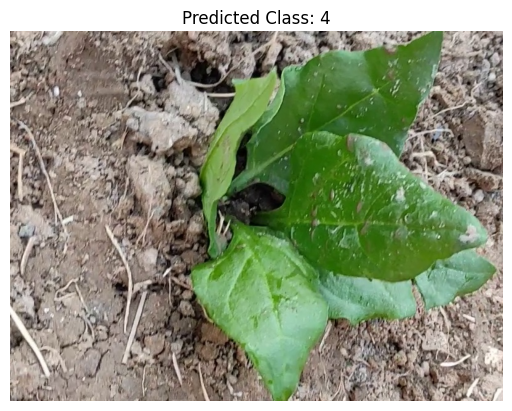

In [45]:
# Ruta de la imagen a probar
# image_path = '/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/Images_prueba/acelga_08989.jpg'  # Cambia esto a la ruta de tu imagen
# image_path = '/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/Images_prueba/cebolla_00386.jpg'
image_path = '/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/Images_prueba/espinaca_00408.jpg'
# image_path = '/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/Images_prueba/lechuga_00066.jpg'
# image_path = '/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/Images_prueba/toronjil_00022.jpg'

# Obtener la clase predicha
predicted_class = predict_image2(image_path)

# Mostrar la imagen y el resultado
image = Image.open(image_path)
plt.imshow(image)
plt.title(f'Predicted Class: {predicted_class}')
plt.axis('off')
plt.show()

##DETALLES

- Transfer Learning: Se ha aplicado al congelar las capas iniciales del modelo preentrenado ResNet y solo entrenar la última capa completamente conectada.

- Fine Tuning: Se ha realizado desbloqueando las capas adicionales del modelo y ajustándolas mediante el optimizador.

- Regularización y Buenas Prácticas: Se han aplicado técnicas como la normalización de imágenes, optimización con SGD y el uso de DataLoader para una carga eficiente de datos.